In [11]:
import sys
!python --version
import numpy as np
import xarray as xr
import itertools as it
import multiprocessing as mp
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.rcsetup as rcsetup
import tensorflow as tf
import sklearn

CPU_COUNT = mp.cpu_count()
print('{} CPUs'.format(CPU_COUNT))
print('numpy version: {}'.format(np.__version__))
print('xarray version: {}'.format(xr.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
print('sklearn version: {}'.format(sklearn.__version__))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Python 3.7.2
32 CPUs
numpy version: 1.15.4
xarray version: 0.11.0
matplotlib version: 3.0.3
sklearn version: 0.19.2


In [12]:
X_ds = xr.open_dataset('data/rcp26/MIROC5/rcp26_MIROC5_grid.nc')
X_arr = X_ds['tas'].values
shape = X_arr.shape
X_monthly = X_arr.reshape((int(shape[0] / 12), 12, shape[1], shape[2]))
monthly_means = np.mean(X_monthly, axis=0)
X_monthly_c = X_monthly - monthly_means
X_c = X_monthly_c.reshape(shape)
X_flat = X_arr.reshape((X_arr.shape[0], X_arr.shape[1]*X_arr.shape[2]))
print(X_ds)

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 2880)
Coordinates:
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
    years    (time) int64 ...
    months   (time) object ...
Dimensions without coordinates: time
Data variables:
    tas      (time, lat, lon) float64 -1.29 -1.29 -1.288 ... 4.061 4.039 4.015


In [13]:
print(X_c.shape)
print(X_flat.shape)

(2880, 72, 144)
(2880, 10368)


In [14]:
from keras.layers import Input, Dense, BatchNormalization
from keras.regularizers import l1,l2
from keras.models import Model

BATCH_SIZE = int(X_flat.shape[0] / 10)

input_0 = Input(batch_shape=(BATCH_SIZE, X_flat.shape[1]))
dense_1 = Dense(32, activation='relu', kernel_regularizer=l1(1.0e-5))(input_0)
dense_3 = Dense(X_flat.shape[1], activation='linear')(dense_1)

model = Model(inputs=input_0, outputs=dense_3)
model.compile(optimizer='adam', loss='mse')

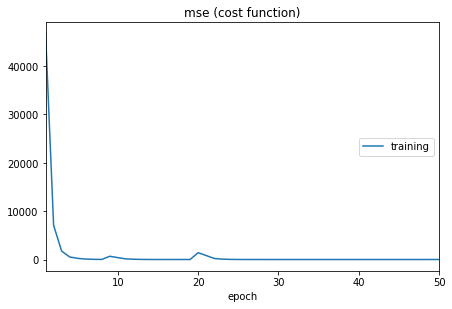

mse (cost function):
training   (min:   48.308, max: 46651.363, cur:   49.428)


In [48]:
from livelossplot.keras import PlotLossesCallback

model.fit(X_flat, X_flat, batch_size=BATCH_SIZE, epochs=50, callbacks=[PlotLossesCallback()])

In [27]:
from keras.layers import *
from keras.regularizers import l1,l2
from keras.models import Model

BATCH_SIZE = int(X_flat.shape[0] / 10)

input_0 = Input(batch_shape=(BATCH_SIZE, X_c.shape[1], X_c.shape[2], 1))
conv_0 = Conv2D(16, (3,3), strides=(2,4), activation='relu', padding='same')(BatchNormalization()(input_0))
conv_1 = Conv2D(8, (3,3), strides=(2,2), activation='relu', padding='same')(BatchNormalization()(conv_0))
conv_2 = Conv2D(4, (3,3), strides=(2,2), activation='relu', padding='same')(BatchNormalization()(conv_1))

conv_3 = Conv2D(4, (3,3), activation='relu', padding='same')(conv_2)
conv_4 = Conv2D(8, (3,3), activation='relu', padding='same')(UpSampling2D((2,2))(conv_3))
conv_5 = Conv2D(16, (3,3), activation='relu', padding='same')(UpSampling2D((2,2))(conv_4))
conv_6 = Conv2D(1, (3,3), padding='same')(UpSampling2D((2,4))(conv_5))

conv_model = Model(inputs=input_0, outputs=conv_6)
conv_model.compile(optimizer='adam', loss='mse')
print(conv_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (288, 72, 144, 1)         0         
_________________________________________________________________
batch_normalization_26 (Batc (288, 72, 144, 1)         4         
_________________________________________________________________
conv2d_49 (Conv2D)           (288, 36, 36, 16)         160       
_________________________________________________________________
batch_normalization_27 (Batc (288, 36, 36, 16)         64        
_________________________________________________________________
conv2d_50 (Conv2D)           (288, 18, 18, 8)          1160      
_________________________________________________________________
batch_normalization_28 (Batc (288, 18, 18, 8)          32        
_________________________________________________________________
conv2d_51 (Conv2D)           (288, 9, 9, 4)            292       
__________

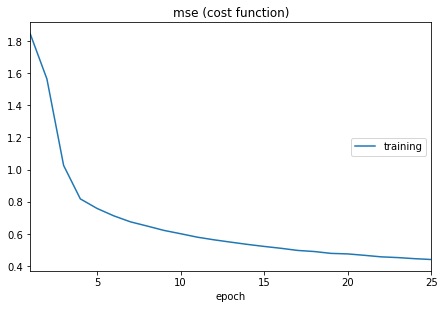

mse (cost function):
training   (min:    0.441, max:    1.844, cur:    0.441)


In [28]:
from livelossplot.keras import PlotLossesCallback

X_c_in = np.expand_dims(X_c, axis=3)
assert X_c_in.shape == (X_c.shape[0], X_c.shape[1], X_c.shape[2], 1), X_c_in.shape
conv_model.fit(X_c_in, X_c_in, batch_size=BATCH_SIZE, epochs=25, callbacks=[PlotLossesCallback()])